# Introduction

Goals:
* Determine if certain residue positions move more than others
* Describe the movement of each CDR loop

In [1]:
import os
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from python_pdb.aligners import align_pandas_structure
from python_pdb.chemistry import MOLECULAR_WEIGHTS
from python_pdb.parsers import parse_pdb_to_pandas
from python_pdb.comparisons import rmsd

from tcr_pmhc_structure_tools.imgt_numbering import assign_cdr_number
from tcr_pmhc_structure_tools.align import align_tcrs

In [2]:
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg')

In [3]:
DATA_DIR = '../data/tcr-pmhc'

# Measuring movement for each residue position

## Collecting Measurements

In [4]:
def get_chain_assignments(file_path):
    chains = file_path.split('/')[-1].split('_')[1]
    
    return {chain: annotation 
            for chain, annotation in zip(chains, ['alpha_chain', 'beta_chain', 'antigen_chain', 'mhc_chain1', 'mhc_chain2'][:len(chains)])}

def get_coords(df):
    return df[['pos_x', 'pos_y', 'pos_z']].to_numpy()

def get_distances(vec1, vec2):
    xx = np.square(vec1[:, 0] - vec2[:, 0])
    yy = np.square(vec1[:, 1] - vec2[:, 1])
    zz = np.square(vec1[:, 2] - vec2[:, 2])
    
    return np.sqrt(xx + yy + zz)

def get_distance(vec1, vec2):
    xx = np.square(vec1[0] - vec2[0])
    yy = np.square(vec1[1] - vec2[1])
    zz = np.square(vec1[2] - vec2[2])
    
    return np.sqrt(xx + yy + zz)

In [5]:
CHI_ATOMS = pd.read_csv('../data/atoms-in-chi-1-angles.csv', index_col='tlc')

def measure_chi_angle(residue_df: pd.DataFrame) -> float:
    res_name = residue_df.iloc[0]['residue_name']
    chi_atoms = CHI_ATOMS.loc[res_name][['atom_1', 'atom_2', 'atom_3', 'atom_4']].to_list()
    
    atom_positions = [residue_df.query("atom_name == @atom")[['pos_x', 'pos_y', 'pos_z']].iloc[0].to_numpy() for atom in chi_atoms]
    
    b1 = atom_positions[1] - atom_positions[0]
    b2 = atom_positions[2] - atom_positions[1]
    b3 = atom_positions[3] - atom_positions[1]
    
    b1_norm = b1 / np.linalg.norm(b1)
    b2_norm = b2 / np.linalg.norm(b2)
    b3_norm = b3 / np.linalg.norm(b3)
    
    n1 = np.cross(b1_norm, b2_norm)
    n2 = np.cross(b2_norm, b3_norm)
    
    m1 = np.cross(n1, b2_norm)
    
    x = np.dot(n1, n2)
    y = np.dot(m1, n2)
    
    return np.arctan2(x, y)

In [6]:
def compute_residue_com(residue: pd.DataFrame) -> np.array:
    '''Compute the centre of mass for a residue.'''
    weights = residue['element'].map(MOLECULAR_WEIGHTS)
    coords = get_coords(residue)

    return np.average(coords, weights=weights, axis=0)

In [7]:
# Info
groups = []
struct1s = []
struct2s = []
cdrs = []
chain_types = []
residue_names = []
residue_seq_ids = []
residue_insert_codes = []

# Measurements
ca_distances = []
rmsds = []
chi_angle_changes = []
com_distances = []

for group in (dir_ for dir_ in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, dir_))):
    print(group)
    
    pdb_files = [file for file in os.listdir(os.path.join(DATA_DIR, group)) if file.endswith('.pdb')]
    
    for path1, path2 in itertools.combinations(pdb_files, 2):
        print(path1, path2)
        
        state1 = path1.split('.')[0].split('_')[-1]
        state2 = path2.split('.')[0].split('_')[-1]

        # Skip holo-holo and apo-apo comparisons for now
        if state1 == state2:
            continue

        if state1 == 'apo':
            apo_path = path1
            holo_path = path2
        else:
            apo_path = path2
            holo_path = path1
        
        chains_apo = get_chain_assignments(apo_path)
        chains_holo = get_chain_assignments(holo_path)
        
        # Load Structures
        with open(os.path.join(DATA_DIR, group, apo_path), 'r') as fh:
            apo_df = parse_pdb_to_pandas(fh.read())
        
        with open(os.path.join(DATA_DIR, group, holo_path), 'r') as fh:
            holo_df = parse_pdb_to_pandas(fh.read())
        
        # Annotate records
        apo_df['chain_type'] = apo_df['chain_id'].map(lambda chain_id: chains_apo[chain_id])
        holo_df['chain_type'] = holo_df['chain_id'].map(lambda chain_id: chains_holo[chain_id])
        
        apo_df['cdr'] = apo_df['residue_seq_id'].map(assign_cdr_number)
        holo_df['cdr'] = holo_df['residue_seq_id'].map(assign_cdr_number)
        
        apo_tcr_df = apo_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
        holo_tcr_df = holo_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
        
        # Query desired residues/atoms
        for chain_type, cdr_number in itertools.product(['alpha_chain', 'beta_chain'], [1, 2, 3]):
            apo_cdr = apo_tcr_df.query("cdr == @cdr_number and chain_type == @chain_type")
            holo_cdr = holo_tcr_df.query("cdr == @cdr_number and chain_type == @chain_type")

            apo_backbone_cdr_coords = get_coords(apo_cdr.query("atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'"))
            holo_backbone_cdr_coords = get_coords(holo_cdr.query("atom_name == 'N' or atom_name == 'CA' or atom_name == 'C' or atom_name == 'O'"))

            holo_cdr = align_pandas_structure(holo_backbone_cdr_coords, apo_backbone_cdr_coords, holo_cdr)
            
            # Compute CA distance
            distance = get_distances(get_coords(apo_cdr.query("atom_name == 'CA'")),
                                     get_coords(holo_cdr.query("atom_name == 'CA'")))
            
            cdr_rmsds = []
            cdr_angle_changes = []
            cdr_com_distances = []
            
            cdr_residue_names = []
            cdr_seq_ids = []
            cdr_insert_codes = []
            
            group1 = apo_cdr.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False)
            group2 = holo_cdr.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False)
            
            for ((res_name, seq_id, insert_code), res1), (_, res2) in zip(group1, group2):
                # Compute Residue RMSD
                try:
                    cdr_rmsds.append(rmsd(get_coords(res1), get_coords(res2)))
                except ValueError:
                    print('Mismatched number of atoms in residue:')
                    print(path1, path2, res_name, seq_id, insert_code)
                    cdr_rmsds.append(None)
                
                # Compute chi angle changes
                if res_name == 'GLY' or res_name == 'ALA':
                    cdr_angle_changes.append(None)
                else:
                    try:
                        cdr_angle_changes.append(measure_chi_angle(res1) - measure_chi_angle(res2))
                    except IndexError:
                        print('Missing atoms needed to calculate chi angle:')
                        print(path1, path2, res_name, seq_id, insert_code)
                        cdr_angle_changes.append(None)

                # Compute C.O.M changes
                cdr_com_distances.append(get_distance(compute_residue_com(res1), compute_residue_com(res2)))

                cdr_residue_names.append(res_name)
                cdr_seq_ids.append(seq_id)
                cdr_insert_codes.append(insert_code)
            
            # append values to lists
            num_residues = len(cdr_residue_names)
            
            residue_names += cdr_residue_names
            residue_seq_ids += cdr_seq_ids
            residue_insert_codes += cdr_insert_codes
            
            ca_distances += list(distance)
            rmsds += cdr_rmsds
            chi_angle_changes += cdr_angle_changes
            com_distances += cdr_com_distances
            
            groups += [group] * num_residues
            struct1s += [path1] * num_residues
            struct2s += [path2] * num_residues
            
            cdrs += [cdr_number] * num_residues
            chain_types += [chain_type] * num_residues

results = pd.DataFrame({
    'group': groups,
    'struct1': struct1s,
    'struct2': struct2s,
    'cdr': cdrs,
    'chain_type': chain_types,
    'residue_name': residue_names,
    'residue_seq_id': residue_seq_ids,
    'residue_insert_code': residue_insert_codes,
    'ca_distance': ca_distances,
    'rmsd': rmsds,
    'chi_angle_change': chi_angle_changes,
    'com_distance': com_distances,
})
results

DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGTGINYGYT
7r80_ABEC_holo.pdb 7r7z_AB_apo.pdb
Mismatched number of atoms in residue:
7r80_ABEC_holo.pdb 7r7z_AB_apo.pdb GLU 65 nan
Missing atoms needed to calculate chi angle:
7r80_ABEC_holo.pdb 7r7z_AB_apo.pdb GLU 65 nan
Mismatched number of atoms in residue:
7r80_ABEC_holo.pdb 7r7z_AB_apo.pdb ILE 117 nan
Missing atoms needed to calculate chi angle:
7r80_ABEC_holo.pdb 7r7z_AB_apo.pdb ILE 117 nan
Mismatched number of atoms in residue:
7r80_ABEC_holo.pdb 7r7z_AB_apo.pdb SER 107 nan
Missing atoms needed to calculate chi angle:
7r80_ABEC_holo.pdb 7r7z_AB_apo.pdb SER 107 nan
NSASQS-VYSSG-VVQPGGYQKVT-MNHNS-SASEGT-ASSEGLWQVGDEQY
6vrm_DEPA_holo.pdb 6vth_DE_apo.pdb
Mismatched number of atoms in residue:
6vrm_DEPA_holo.pdb 6vth_DE_apo.pdb LYS 115 nan
Missing atoms needed to calculate chi angle:
6vrm_DEPA_holo.pdb 6vth_DE_apo.pdb LYS 115 nan
NSAFQY-TYSSGN-AMRGDSSYKLI-SGHDY-FNNNVP-ASSLWEKLAKNIQY
5c0a_DECA_holo.pdb 5hyj_DECA_holo.pdb
5c0a_DECA_holo.pdb 3u

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,ca_distance,rmsd,chi_angle_change,com_distance
0,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,1,alpha_chain,ALA,29,NaN,2.531605,1.285409,NaN,0.921471
1,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,1,alpha_chain,ASN,38,NaN,1.982218,0.730495,-0.105521,0.639094
2,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,1,alpha_chain,ASP,27,NaN,0.637322,4.945138,1.246507,3.537430
3,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,1,alpha_chain,ILE,36,NaN,0.872186,2.084688,1.827670,1.146069
4,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,1,alpha_chain,SER,28,NaN,0.273485,3.574033,-1.226993,2.045758
...,...,...,...,...,...,...,...,...,...,...,...,...
2634,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlm_DE_apo.pdb,2vlj_DECA_holo.pdb,3,beta_chain,SER,108,NaN,3.003358,2.116952,-3.923139,1.567178
2635,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlm_DE_apo.pdb,2vlj_DECA_holo.pdb,3,beta_chain,SER,110,NaN,2.898981,3.866038,-2.287100,3.604975
2636,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlm_DE_apo.pdb,2vlj_DECA_holo.pdb,3,beta_chain,SER,113,NaN,0.422479,4.304431,-2.136086,3.319092
2637,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlm_DE_apo.pdb,2vlj_DECA_holo.pdb,3,beta_chain,TYR,114,NaN,0.418650,8.409147,1.564728,6.779847


In [8]:
results['resi'] = results['residue_seq_id'].apply(str) + results['residue_insert_code'].fillna('')

results['struct_1_form'] = results['struct1'].map(lambda path: path.split('.')[0].split('_')[-1])
results['struct_2_form'] = results['struct2'].map(lambda path: path.split('.')[0].split('_')[-1])

In [9]:
results = results.groupby(['group',
                            'cdr',
                            'chain_type',
                            'residue_name',
                            'residue_seq_id', 'residue_insert_code', 'resi',
                            'struct_1_form', 'struct_2_form'],
                            dropna=False)[['ca_distance', 'rmsd', 'chi_angle_change', 'com_distance']].mean().reset_index()

## Ca movement

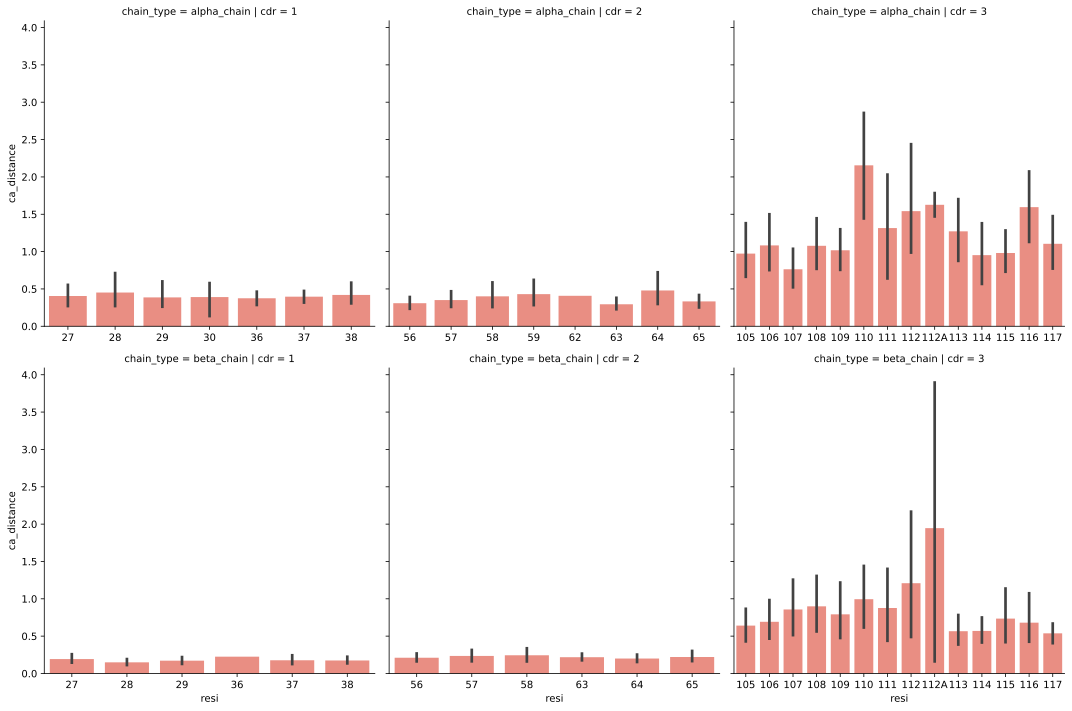

In [10]:
sns.catplot(results.sort_values('resi'),
            x='resi', y='ca_distance',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

## Residue RMSD difference

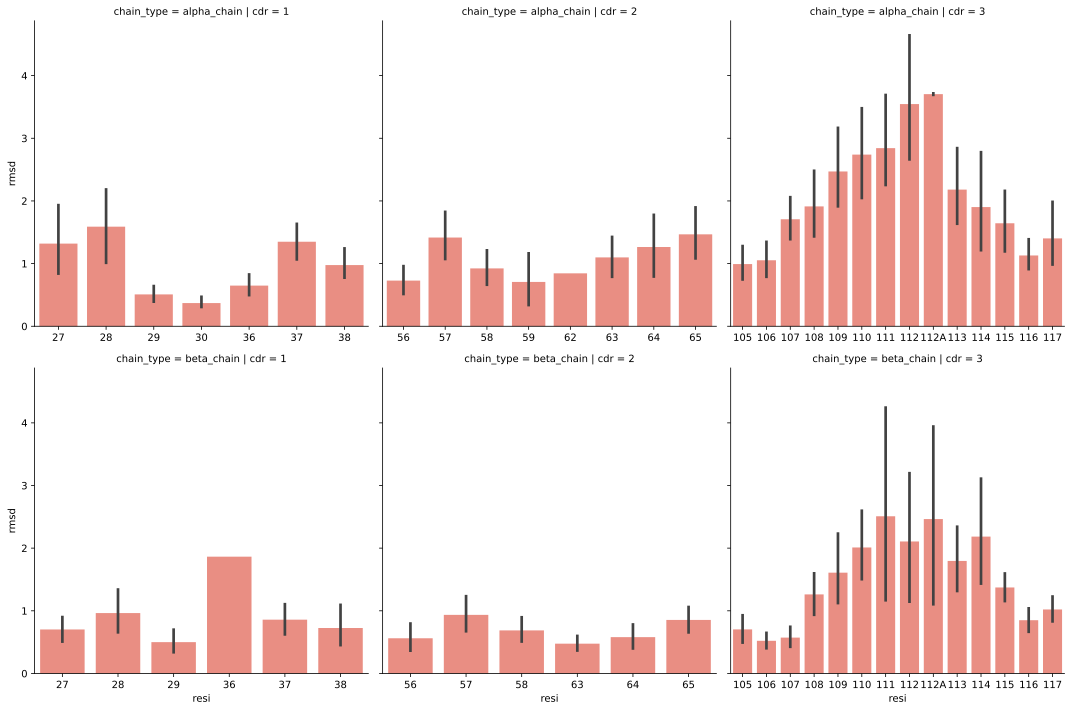

In [11]:
sns.catplot(results.sort_values('resi'),
            x='resi', y='rmsd',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

### Normalized

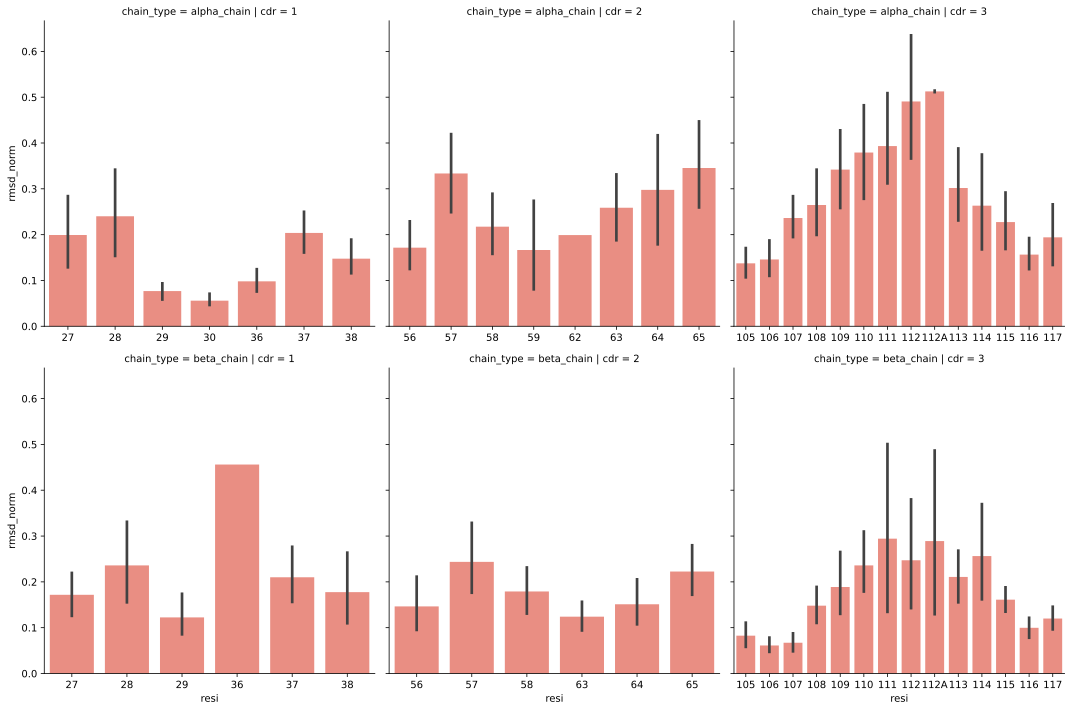

In [12]:
results['rmsd_norm'] = results.groupby(['chain_type', 'cdr'])['rmsd'].transform(lambda x: x / x.max())

sns.catplot(results.sort_values('resi'),
            x='resi', y='rmsd_norm',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

## Centre of Mass Changes

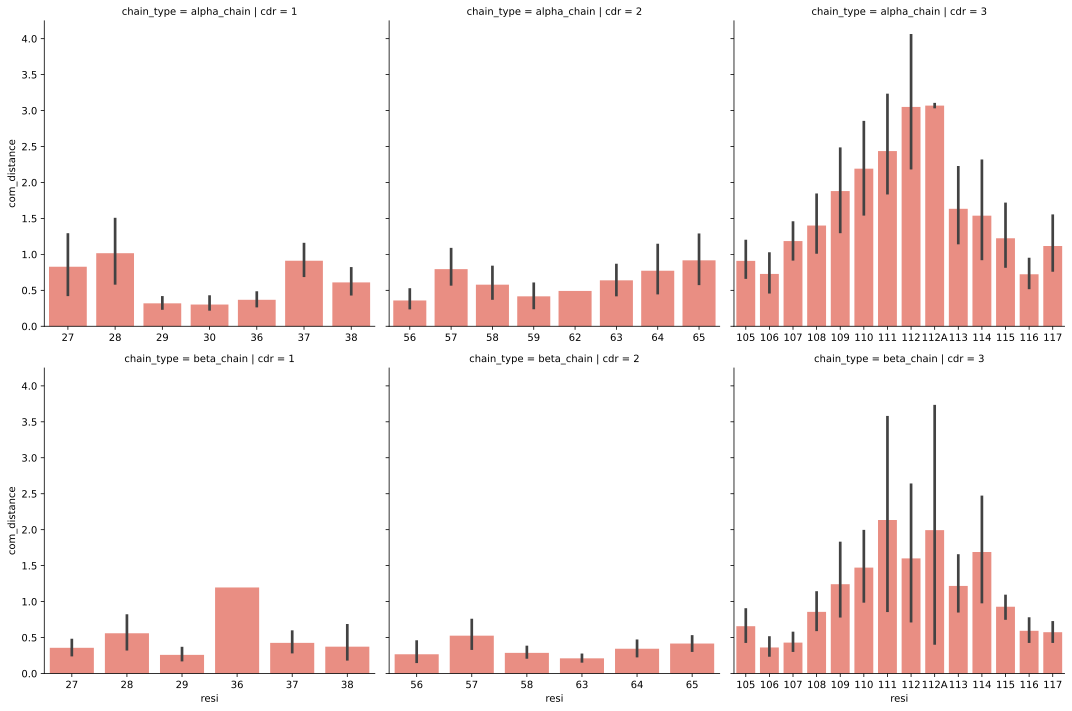

In [13]:
sns.catplot(results.sort_values('resi'),
            x='resi', y='com_distance',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

# Comparing Residue Identity to movment

In [14]:
aa_types = results['residue_name'].map({
    'ARG': 'Charged',
    'HIS': 'Charged',
    'LYS': 'Charged',
    'ASP': 'Charged',
    'GLU': 'Charged',
    'SER': 'Polar',
    'THR': 'Polar',
    'ASN': 'Polar',
    'GLN': 'Polar',
    'CYS': 'Special',
    'GLY': 'Special',
    'PRO': 'Special',
    'ALA': 'Hydrophobic',
    'VAL': 'Hydrophobic',
    'ILE': 'Hydrophobic',
    'LEU': 'Hydrophobic',
    'MET': 'Hydrophobic',
    'PHE': 'Hydrophobic',
    'TYR': 'Hydrophobic',
    'TRP': 'Hydrophobic',
})

colour = aa_types.map({
    'Charged': 'lightblue',
    'Polar': 'orange',
    'Special': 'yellow',
    'Hydrophobic': 'pink',
})

In [15]:
aa_means = results.groupby('residue_name')['rmsd'].mean().to_dict()
results['aa_mean'] = results['residue_name'].map(aa_means)

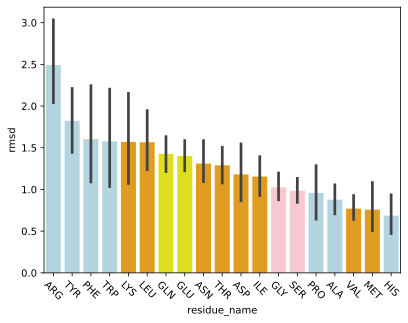

In [16]:
sns.barplot(results.sort_values('aa_mean', ascending=False), y='rmsd', x='residue_name', palette=colour)
plt.xticks(rotation=-45)
print()

In [17]:
num_side_chain_heavy_atoms = results['residue_name'].map({
    'ARG': 7,
    'HIS': 7,
    'LYS': 5,
    'ASP': 4,
    'GLU': 5,
    'SER': 2,
    'THR': 3,
    'ASN': 4,
    'GLN': 5,
    'CYS': 2,
    'GLY': 0,
    'PRO': 3,
    'ALA': 1,
    'VAL': 3,
    'ILE': 4,
    'LEU': 4,
    'MET': 4,
    'PHE': 7,
    'TYR': 8,
    'TRP': 10,
})

Text(0.5, 0, 'number of heavy atoms in side chain')

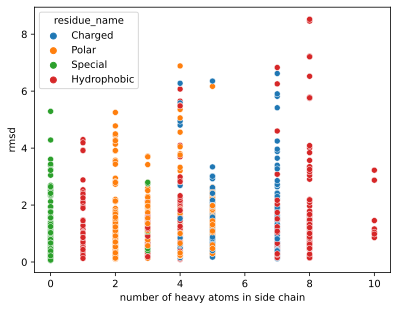

In [18]:
sns.scatterplot(x=num_side_chain_heavy_atoms, y=results['rmsd'], hue=aa_types)

plt.xlabel('number of heavy atoms in side chain')

# Meseasuring differences in $\chi$-angles

Do the side chains change conformation as well?

In [19]:
results['chi_angle_change_mag'] = results['chi_angle_change'].apply(np.abs)
results['chi_angle_change_deg_mag'] = results['chi_angle_change_mag'].apply(np.degrees)

/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


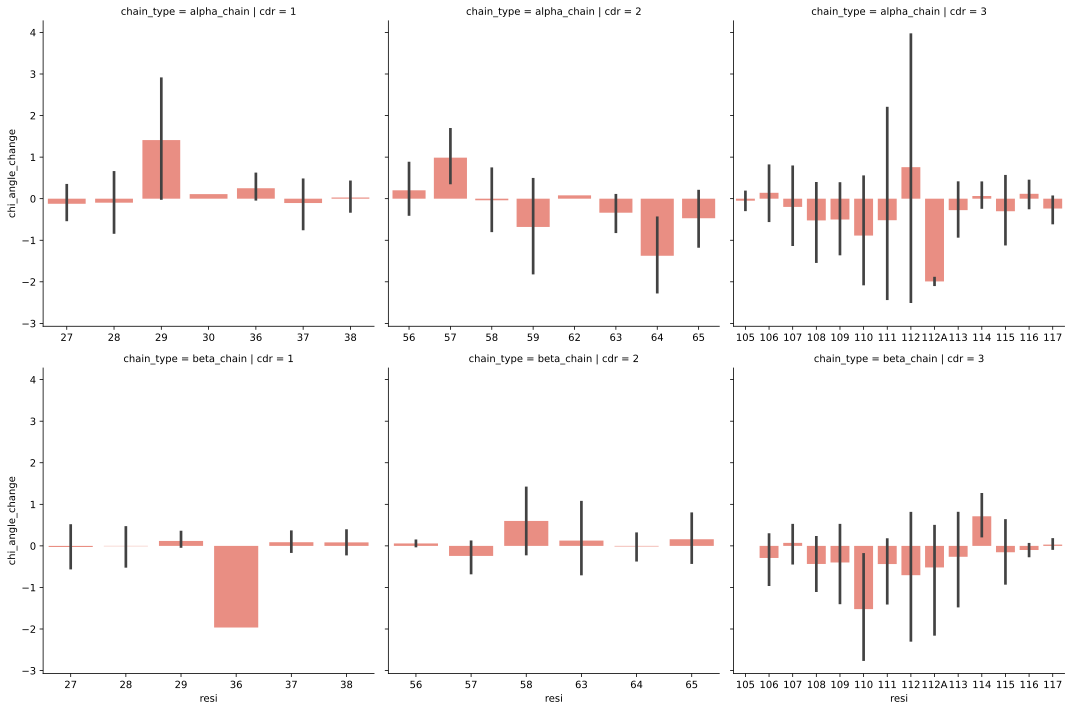

In [20]:
sns.catplot(results.sort_values('resi'),
            x='resi', y='chi_angle_change',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


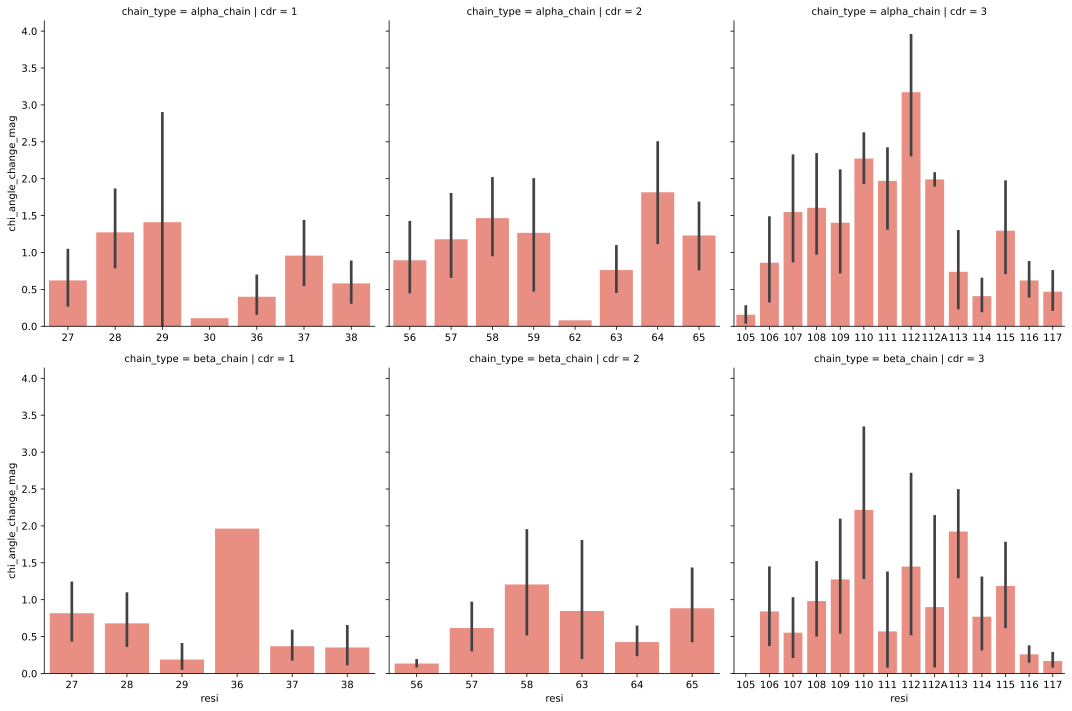

In [21]:
sns.catplot(results.sort_values('resi'),
            x='resi', y='chi_angle_change_mag',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/benjie/miniconda3/envs/tcr-pmhc-interface-analysis/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


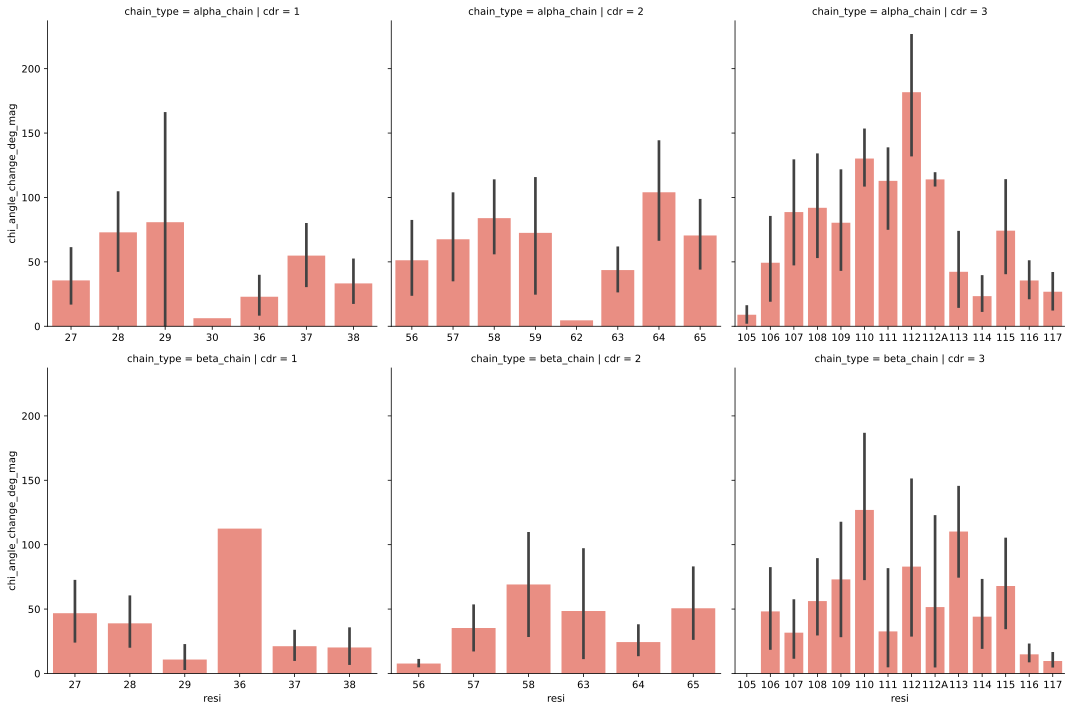

In [22]:
sns.catplot(results.sort_values('resi'),
            x='resi', y='chi_angle_change_deg_mag',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

## $\phi$- and $\psi$- angle deviations

In [23]:
def calculate_angle(v1, v2):
    n1 = np.linalg.norm(v1)
    n2 = np.linalg.norm(v2)
    
    cos_theta = np.dot(v1, v2) / (n1 * n2)
    
    cos_theta = min(cos_theta, 1)
    cos_theta = max(cos_theta, -1)
    
    return np.arccos(cos_theta)

def calculate_dihedral_angle(a, b, c, d):
    ba = a - b
    bc = c - b
    cd = d - c
    
    u = np.cross(ba, bc)
    v = np.cross(cd, bc)
    
    w = np.cross(u, v)
    
    angle = calculate_angle(u, v)
    
    if calculate_angle(bc, w) > 0.001:
        angle = -angle

    return angle

def calculate_phi_psi_angles(residue: pd.DataFrame, prev_residue: pd.DataFrame, next_residue: pd.DataFrame) -> tuple[float, float]:
    '''Calculate the dihedral (phi and psi) angles for a given residue.'''
    c_prev_pos = prev_residue.query("atom_name == 'C'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]
    
    n_pos = residue.query("atom_name == 'N'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]
    ca_pos = residue.query("atom_name == 'CA'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]
    c_pos = residue.query("atom_name == 'C'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]

    n_next_pos = next_residue.query("atom_name == 'N'")[['pos_x', 'pos_y', 'pos_z']].iloc[0]
    
    phi_angle = calculate_dihedral_angle(c_prev_pos, n_pos, ca_pos, c_pos)
    psi_angle = calculate_dihedral_angle(n_pos, ca_pos, c_pos, n_next_pos)
    
    return (phi_angle, psi_angle)

In [24]:
def find_anchors(cdr_df, structure_df):
    cdr_start = cdr_df.iloc[0].name
    cdr_end = cdr_df.iloc[-1].name

    start_anchor_info = structure_df.loc[:cdr_start].tail(1).iloc[0][['chain_id', 'residue_seq_id', 'residue_insert_code']]
    end_anchor_info = structure_df.loc[cdr_end:].head(2).iloc[1][['chain_id', 'residue_seq_id', 'residue_insert_code']]

    if start_anchor_info['residue_insert_code']:
        start_anchor = structure_df.query(('chain_id == @start_anchor_info.chain_id'
                                           ' and residue_seq_id == @start_anchor_info.residue_seq_id'
                                           ' and residue_insert_code == @start_anchor_info.residue_insert_code'))

    else:
        start_anchor = structure_df.query(('chain_id == @start_anchor_info.chain_id'
                                           ' and residue_seq_id == @start_anchor_info.residue_seq_id'
                                           ' and residue_insert_code.isnull()'))

    if end_anchor_info['residue_insert_code']:
        end_anchor = structure_df.query(('chain_id == @end_anchor_info.chain_id'
                                         ' and residue_seq_id == @end_anchor_info.residue_seq_id'
                                         ' and residue_insert_code == @end_anchor_info.residue_insert_code'))

    else:
        end_anchor = structure_df.query(('chain_id == @end_anchor_info.chain_id'
                                         ' and residue_seq_id == @end_anchor_info.residue_seq_id'
                                         ' and residue_insert_code.isnull()'))
    
    return start_anchor, end_anchor

In [25]:
# Info
group_names = []
struct1s = []
struct2s = []
cdrs = []
chain_types = []
residue_names = []
residue_seq_ids = []
residue_insert_codes = []

# Measurements
apo_phis = []
apo_psis = []
holo_phis = []
holo_psis = []

for group in (dir_ for dir_ in os.listdir(DATA_DIR) if os.path.isdir(os.path.join(DATA_DIR, dir_))):
    print(group)
    
    pdb_files = [file for file in os.listdir(os.path.join(DATA_DIR, group)) if file.endswith('.pdb')]
    
    for path1, path2 in itertools.combinations(pdb_files, 2):
        print(path1, path2)
        
        state1 = path1.split('.')[0].split('_')[-1]
        state2 = path2.split('.')[0].split('_')[-1]

        # Skip holo-holo and apo-apo comparisons for now
        if state1 == state2:
            continue

        if state1 == 'apo':
            apo_path = path1
            holo_path = path2
        else:
            apo_path = path2
            holo_path = path1
        
        chains_apo = get_chain_assignments(apo_path)
        chains_holo = get_chain_assignments(holo_path)
        
        # Load Structures
        with open(os.path.join(DATA_DIR, group, apo_path), 'r') as fh:
            apo_df = parse_pdb_to_pandas(fh.read())
        
        with open(os.path.join(DATA_DIR, group, holo_path), 'r') as fh:
            holo_df = parse_pdb_to_pandas(fh.read())
        
        # Annotate records
        apo_df['chain_type'] = apo_df['chain_id'].map(lambda chain_id: chains_apo[chain_id])
        holo_df['chain_type'] = holo_df['chain_id'].map(lambda chain_id: chains_holo[chain_id])
        
        apo_df['cdr'] = apo_df['residue_seq_id'].map(assign_cdr_number)
        holo_df['cdr'] = holo_df['residue_seq_id'].map(assign_cdr_number)
        
        apo_tcr_df = apo_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
        holo_tcr_df = holo_df.query("chain_type == 'alpha_chain' or chain_type == 'beta_chain'")
        
        apo_tcr_df = align_tcrs(apo_tcr_df, holo_tcr_df)
        
        # Query desired residues/atoms
        for chain_type, cdr_number in itertools.product(['alpha_chain', 'beta_chain'], [1, 2, 3]):
            apo_cdr = apo_tcr_df.query("cdr == @cdr_number and chain_type == @chain_type")
            holo_cdr = holo_tcr_df.query("cdr == @cdr_number and chain_type == @chain_type")
            
            # add anchors to cdr loops
            apo_start_anchor, apo_end_anchor = find_anchors(apo_cdr, apo_tcr_df)
            apo_cdr = pd.concat([apo_start_anchor, apo_cdr, apo_end_anchor])
            
            holo_start_anchor, holo_end_anchor = find_anchors(holo_cdr, holo_tcr_df)
            holo_cdr = pd.concat([holo_start_anchor, holo_cdr, holo_end_anchor])
            
            # Group Residues
            group_apo = apo_cdr.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False)
            group_holo = holo_cdr.groupby(['residue_name', 'residue_seq_id', 'residue_insert_code'], dropna=False)
            
            groups = list(zip(group_apo, group_holo))
            num_residues = len(groups)
            
            cdr_res_names = []
            cdr_seq_ids = []
            cdr_insert_codes = []
            
            cdr_apo_phis = []
            cdr_apo_psis = []
            
            cdr_holo_phis = []
            cdr_holo_psis = []
            
            for i, (((res_name, seq_id, insert_code), res1), (_, res2)) in enumerate(groups):
                if i == 0 or i == num_residues - 1:  # ignore anchor residues
                    continue
                
                prev_res_1 = groups[i - 1][0][-1]
                next_res_1 = groups[i + 1][0][-1]
                
                prev_res_2 = groups[i - 1][1][-1]
                next_res_2 = groups[i + 1][1][-1]
                
                phi_1, psi_1 = calculate_phi_psi_angles(res1, prev_res_1, next_res_1)
                phi_2, psi_2 = calculate_phi_psi_angles(res2, prev_res_2, next_res_2)
                
                cdr_res_names.append(res_name)
                cdr_seq_ids.append(seq_id)
                cdr_insert_codes.append(insert_code)
            
                cdr_apo_phis.append(phi_1)
                cdr_apo_psis.append(psi_1)
            
                cdr_holo_phis.append(phi_2)
                cdr_holo_psis.append(psi_2)
            
            num_residues = len(cdr_res_names)
            
            residue_names += cdr_res_names
            residue_seq_ids += cdr_seq_ids
            residue_insert_codes += cdr_insert_codes
            
            apo_phis += cdr_apo_phis
            apo_psis += cdr_apo_psis
            
            holo_phis += cdr_holo_phis
            holo_psis += cdr_holo_psis
            
            group_names += [group] * num_residues
            struct1s += [path1] * num_residues
            struct2s += [path2] * num_residues
            
            cdrs += [cdr_number] * num_residues
            chain_types += [chain_type] * num_residues
            
results_phi_psi = pd.DataFrame({
    'group': group_names,
    'struct1': struct1s,
    'struct2': struct2s,
    'cdr': cdrs,
    'chain_type': chain_types,
    'residue_name': residue_names,
    'residue_seq_id': residue_seq_ids,
    'residue_insert_code': residue_insert_codes,
    'apo_phi': apo_phis,
    'apo_psi': apo_psis,
    'holo_phi': holo_phis,
    'holo_psi': holo_psis,
})

results_phi_psi

DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGTGINYGYT
7r80_ABEC_holo.pdb 7r7z_AB_apo.pdb
NSASQS-VYSSG-VVQPGGYQKVT-MNHNS-SASEGT-ASSEGLWQVGDEQY
6vrm_DEPA_holo.pdb 6vth_DE_apo.pdb
NSAFQY-TYSSGN-AMRGDSSYKLI-SGHDY-FNNNVP-ASSLWEKLAKNIQY
5c0a_DECA_holo.pdb 5hyj_DECA_holo.pdb
5c0a_DECA_holo.pdb 3utt_DECA_holo.pdb
5c0a_DECA_holo.pdb 3utp_DE_apo.pdb
5c0a_DECA_holo.pdb 5c07_DECA_holo.pdb
5c0a_DECA_holo.pdb 3uts_DECA_holo.pdb
5c0a_DECA_holo.pdb 5c0c_DEHF_holo.pdb
5c0a_DECA_holo.pdb 5c09_IJHF_holo.pdb
5c0a_DECA_holo.pdb 5c0b_IJHF_holo.pdb
5c0a_DECA_holo.pdb 5c08_DECA_holo.pdb
5hyj_DECA_holo.pdb 3utt_DECA_holo.pdb
5hyj_DECA_holo.pdb 3utp_DE_apo.pdb
5hyj_DECA_holo.pdb 5c07_DECA_holo.pdb
5hyj_DECA_holo.pdb 3uts_DECA_holo.pdb
5hyj_DECA_holo.pdb 5c0c_DEHF_holo.pdb
5hyj_DECA_holo.pdb 5c09_IJHF_holo.pdb
5hyj_DECA_holo.pdb 5c0b_IJHF_holo.pdb
5hyj_DECA_holo.pdb 5c08_DECA_holo.pdb
3utt_DECA_holo.pdb 3utp_DE_apo.pdb
3utt_DECA_holo.pdb 5c07_DECA_holo.pdb
3utt_DECA_holo.pdb 3uts_DECA_holo.pdb
3utt_DECA_holo.pdb

,group,struct1,struct2,cdr,chain_type,residue_name,residue_seq_id,residue_insert_code,apo_phi,apo_psi,holo_phi,holo_psi
0,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,1,alpha_chain,ASN,38,NaN,-1.992797,0.673443,-1.992409,0.723640
1,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,1,alpha_chain,ASP,27,NaN,0.773844,-2.497908,-1.753962,2.642968
2,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,1,alpha_chain,ILE,36,NaN,-0.546844,2.198889,-0.992345,2.254197
3,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,1,alpha_chain,LEU,39,NaN,-2.631881,0.887473,-2.818928,0.028758
4,DSAIYN-IQSSQRE-AQLNQAGTALI-MNHEY-SVGAGI-ASSYGT...,7r80_ABEC_holo.pdb,7r7z_AB_apo.pdb,1,alpha_chain,SER,28,NaN,-1.534069,2.010694,1.529700,-1.517025
...,...,...,...,...,...,...,...,...,...,...,...,...
2292,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlm_DE_apo.pdb,2vlj_DECA_holo.pdb,3,beta_chain,SER,107,NaN,-2.661537,2.899484,-2.599406,2.579923
2293,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlm_DE_apo.pdb,2vlj_DECA_holo.pdb,3,beta_chain,SER,108,NaN,-1.048377,-2.305288,-0.738324,-0.076586
2294,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlm_DE_apo.pdb,2vlj_DECA_holo.pdb,3,beta_chain,SER,110,NaN,-0.196343,0.794142,-1.319343,2.423673
2295,SVFSS-VVTGGEV-AGAGSQGNLI-LNHDA-SQIVND-ASSSRSSYEQY,2vlm_DE_apo.pdb,2vlj_DECA_holo.pdb,3,beta_chain,SER,113,NaN,-2.691747,2.705731,1.399422,-0.087100


In [26]:
results_phi_psi = results_phi_psi.groupby(['group',
                                           'cdr',
                                           'chain_type',
                                           'residue_name',
                                           'residue_seq_id',
                                           'residue_insert_code'],
                                           dropna=False)[['apo_phi', 'apo_psi', 'holo_phi', 'holo_psi']].mean().reset_index()

In [27]:
results_phi_psi['phi_change'] = results_phi_psi['apo_phi'] - results_phi_psi['holo_phi']
results_phi_psi['psi_change'] = results_phi_psi['apo_psi'] - results_phi_psi['holo_psi']

In [28]:
results_phi_psi['phi_change_mag'] = results_phi_psi['phi_change'].apply(np.abs)
results_phi_psi['phi_change_mag_deg'] = results_phi_psi['phi_change_mag'].apply(np.degrees)

results_phi_psi['psi_change_mag'] = results_phi_psi['psi_change'].apply(np.abs)
results_phi_psi['psi_change_mag_deg'] = results_phi_psi['psi_change_mag'].apply(np.degrees)

In [29]:
results_phi_psi['resi'] = results_phi_psi['residue_seq_id'].apply(str) + results_phi_psi['residue_insert_code'].fillna('')

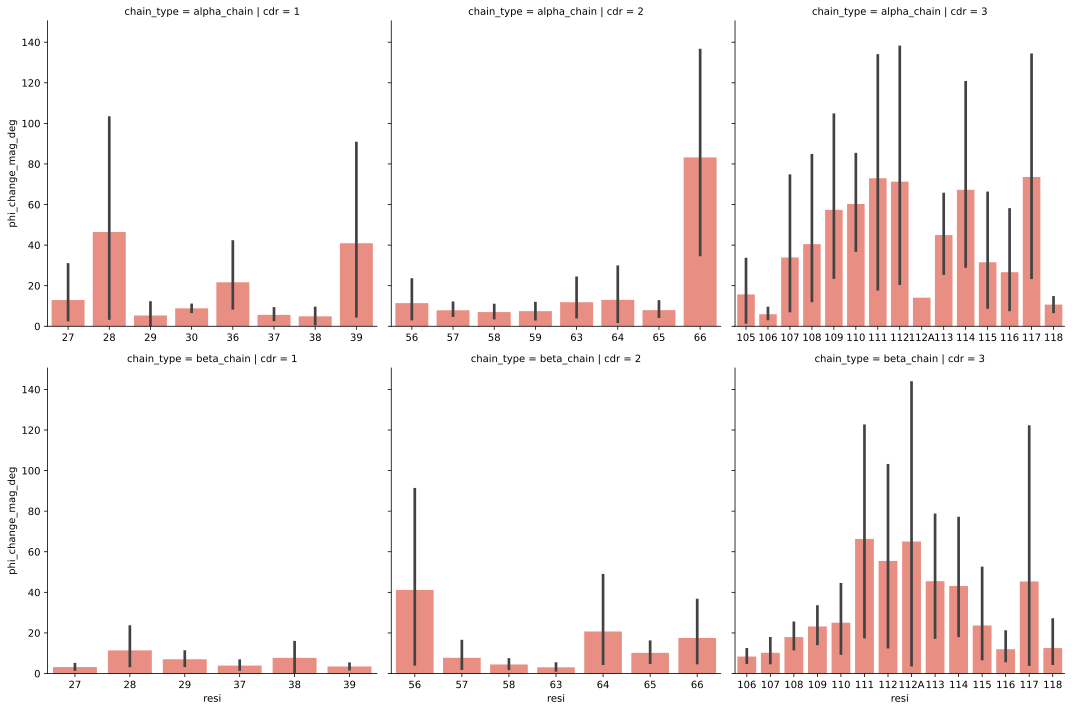

In [30]:
sns.catplot(results_phi_psi.sort_values('resi'),
            x='resi', y='phi_change_mag_deg',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')

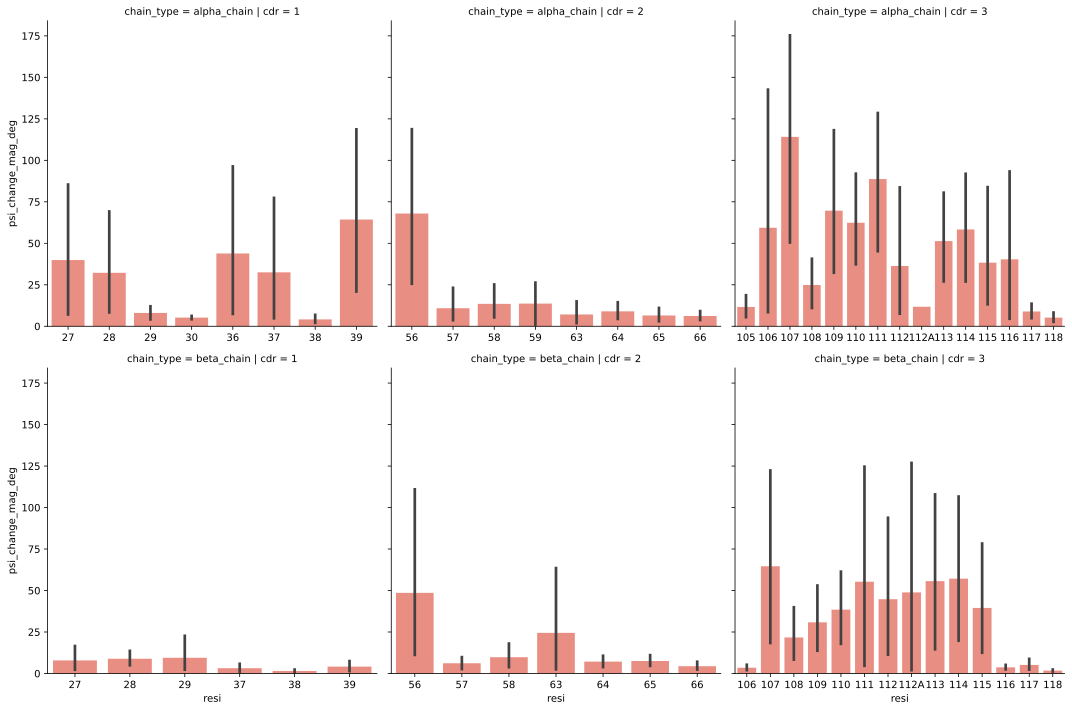

In [31]:
sns.catplot(results_phi_psi.sort_values('resi'),
            x='resi', y='psi_change_mag_deg',
            row='chain_type', col='cdr',
            color='salmon',
            sharex=False,
            kind='bar')